In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import gzip
import typing
import pickle

import numpy as np
import pandas as pd
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.containment_support_dataset import ContainmentSupportDataset, QUINN_SCENE_TYPES


from simple_relational_reasoning.embeddings.visualizations import *
from simple_relational_reasoning.embeddings.stimuli import UNNORMALIZE, NORM_MEAN, NORM_STD

In [2]:
def plot_triplets(triplets, plot_midlines=False, plot_diagonals=False, add_titles=True, save_path=None):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if plot_midlines:
                ax.axhline(y=triplets.shape[-2] // 2, color='black', linestyle='--', alpha=0.5)
                ax.axvline(x=triplets.shape[-1] // 2, color='black', linestyle='--', alpha=0.5)
            
            if plot_diagonals:
                ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=0.5)
                ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=0.5)

            if add_titles:
                if row == 0:
                    if col == k - 1:
                        ax.set_title('Different Relation')
                    elif col == k - 2:
                        ax.set_title('Same Relation')
                    else:
                        ax.set_title(f'Habituation #{col + 1}')

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path)

    plt.show()


In [4]:
def load_tsne_outputs(file_name: str, folder: str = '../tsne_outputs/', extension: str = '.pkl.gz'):
    if not file_name.endswith(extension):
        file_name += extension

    with gzip.open(os.path.join(folder, file_name), 'rb') as f:
        return pickle.load(f)

In [5]:
tsne_outputs = load_tsne_outputs('v3_flapless_stimuli_tsne.pkl.gz', '../containment_support_outputs/')
print(tsne_outputs.keys())
tsne_outputs['mobilenet-random'].shape, type(tsne_outputs['mobilenet-random'])

dict_keys(['mobilenet-saycam(S)', 'mobilenet-imagenet', 'mobilenet-random', 'resnext-saycam(S)', 'resnext-imagenet', 'resnext-random', 'resnext-saycam(S)-s', 'resnext-saycam(S)-h', 'resnext-saycam(S)-v', 'resnext-saycam(S)-hv', 'resnext-DINO-S', 'resnext-DINO-ImageNet'])


((320, 5, 1280), numpy.ndarray)

In [6]:
dataset = ContainmentSupportDataset('/Users/guydavidson/projects/BlockWorld/outputs/containment_v3_flapless_tsne')
dataset.dataset.shape

100%|██████████| 320/320 [00:19<00:00, 16.07it/s]


torch.Size([320, 5, 3, 224, 224])

## Next steps 

* Implement coloring by the different features
* Create t-SNE ebmeddings for each of the models I have
* Plot
* Analyze

In [7]:
def index_by_relation(dataset: ContainmentSupportDataset) -> np.ndarray:
    s = dataset.dataset.shape
    return np.tile(np.arange(s[1]), (s[0], 1)).reshape(-1)


def index_by_target_object(dataset: ContainmentSupportDataset) -> np.ndarray:
    target_object_indices = [dataset.target_objects.index(o) for o in dataset.dataset_target_objects]
    return np.tile(np.array(target_object_indices), (dataset.dataset.shape[1], 1)).T.reshape(-1)


def index_by_reference_object(dataset: ContainmentSupportDataset) -> np.ndarray:
    reference_object_indices = [dataset.reference_objects.index(o) for o in dataset.dataset_reference_objects]
    return np.tile(np.array(reference_object_indices), (dataset.dataset.shape[1], 1)).T.reshape(-1)


def index_by_configuration(dataset: ContainmentSupportDataset) -> np.ndarray:
    return np.tile(np.array(dataset.dataset_configuration_indices), (dataset.dataset.shape[1], 1)).T.reshape(-1)


RELATION = 'relation'
TARGET_OBJECT = 'target_object'
REFERENCE_OBJECT = 'reference_object'
CONFIGURATION = 'configuration'


INDEXING_METHODS = {
    RELATION: index_by_relation,
    TARGET_OBJECT: index_by_target_object,
    REFERENCE_OBJECT: index_by_reference_object,
    CONFIGURATION: index_by_configuration,
}

In [8]:
PCA_N_DIM = 32
SEED = 33
PCA_KWARGS = dict(random_state=SEED)
TSNE_KAWRGS = dict(init='pca', learning_rate='auto', metric='cosine', random_state=SEED)

def pca_and_tsne(data: np.ndarray, pca_n_dim: int = PCA_N_DIM, 
    pca_kwargs: typing.Optional[typing.Dict] = None, tsne_kwargs: typing.Optional[typing.Dict] = None):

    if pca_kwargs is None:
        pca_kwargs = PCA_KWARGS
    else:
        temp_kwargs = PCA_KWARGS.copy()
        temp_kwrags.update(pca_kwargs)
        pca_kwargs = temp_kwargs

    if tsne_kwargs is None:
        tsne_kwargs = TSNE_KAWRGS

    else:
        temp_kwrags = TSNE_KAWRGS.copy()
        temp_kwrags.update(tsne_kwargs)
        tsne_kwargs = temp_kwrags

    if data.ndim > 2:
        data = data.reshape(-1, data.shape[-1])

    pca = PCA(n_components=pca_n_dim, **pca_kwargs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, **tsne_kwargs)
    data_tsne = tsne.fit_transform(data_pca)

    return data_tsne


In [9]:
tsne_results = {}
for key, outputs in tsne_outputs.items():
    print(f'Starting t-SNE for {key}')
    tsne_results[key] = pca_and_tsne(outputs)

Starting t-SNE for mobilenet-saycam(S)
Starting t-SNE for mobilenet-imagenet
Starting t-SNE for mobilenet-random
Starting t-SNE for resnext-saycam(S)
Starting t-SNE for resnext-imagenet
Starting t-SNE for resnext-random
Starting t-SNE for resnext-saycam(S)-s
Starting t-SNE for resnext-saycam(S)-h
Starting t-SNE for resnext-saycam(S)-v
Starting t-SNE for resnext-saycam(S)-hv
Starting t-SNE for resnext-DINO-S
Starting t-SNE for resnext-DINO-ImageNet


In [10]:
tsne_results.keys()

dict_keys(['mobilenet-saycam(S)', 'mobilenet-imagenet', 'mobilenet-random', 'resnext-saycam(S)', 'resnext-imagenet', 'resnext-random', 'resnext-saycam(S)-s', 'resnext-saycam(S)-h', 'resnext-saycam(S)-v', 'resnext-saycam(S)-hv', 'resnext-DINO-S', 'resnext-DINO-ImageNet'])

In [11]:
def get_names(dataset: ContainmentSupportDataset, indexing_method: str) -> typing.List[str]:
    if indexing_method == RELATION:
        return list(dataset.scene_types)
    elif indexing_method == TARGET_OBJECT:
        return dataset.target_objects
    elif indexing_method == REFERENCE_OBJECT:
        return dataset.reference_objects
    elif indexing_method == CONFIGURATION:
        return np.arange(max(dataset.dataset_configuration_indices) + 1).astype(str)
    else:
        raise ValueError(f'Unknown indexing method: {indexing_method}')


def plot_tsne_results(results: typing.Dict[str, np.ndarray],
    model_key: str,
    color_by: str,
    dataset: ContainmentSupportDataset,
    figsize: typing.Tuple[int, int] = (10, 8),
    cmap: str = 'tab10',
    vmin: int = 0,
    vmax: int = 10,
    index_shift: int = 0,
    title_fontsize: int = 16,
    ):

    if model_key not in results:
        raise ValueError(f'Invalid model key: {model_key}')

    if color_by not in INDEXING_METHODS:
        raise ValueError(f'Invalid color_by: {color_by}')

    data = results[model_key]
    index = INDEXING_METHODS[color_by](dataset) + index_shift
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.scatter(data[:, 0], data[:, 1], c=index, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    cbar = plt.colorbar(boundaries=np.arange(index_shift, index.max() + 2), ticks=np.arange(index_shift, index.max() + 1) + 0.5)
    cbar.ax.set_yticklabels([plot_prettify(o, color_by).replace(' ', '\n') for o in get_names(dataset, color_by)], fontsize=title_fontsize-4)

    # plt.title(f'mode by {plot_prettify(color_by, "color_by")}')
    plt.title(f'{"-".join([plot_prettify(model_key_part) for model_key_part in model_key.split("-")])} colored by {plot_prettify(color_by, "color_by")}', fontsize=title_fontsize)
    plt.show()


# mobilenet-saycam(S)

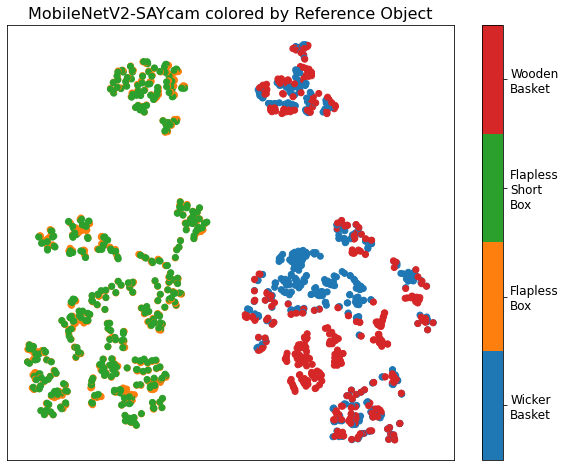

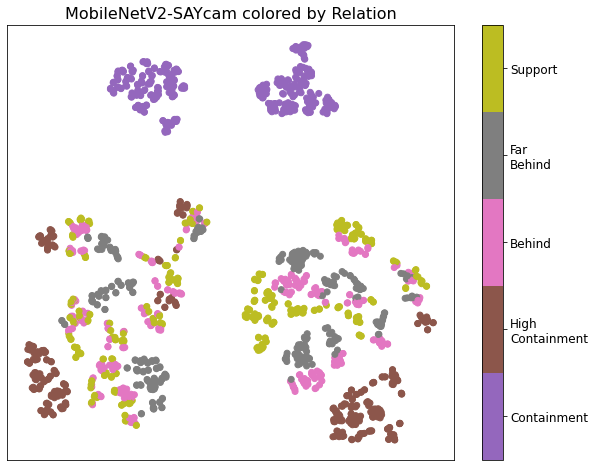

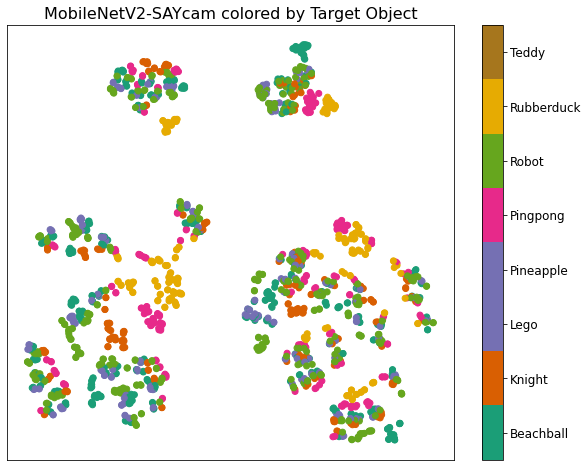

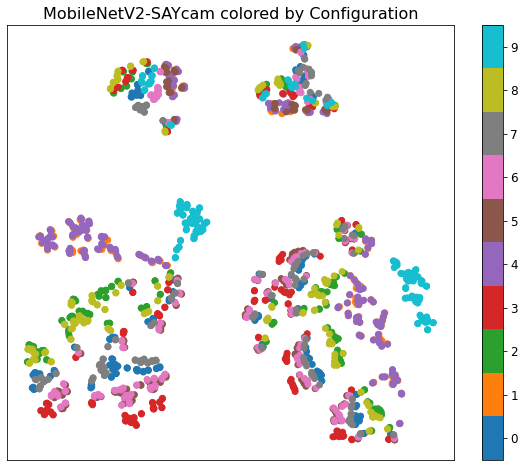

# mobilenet-imagenet

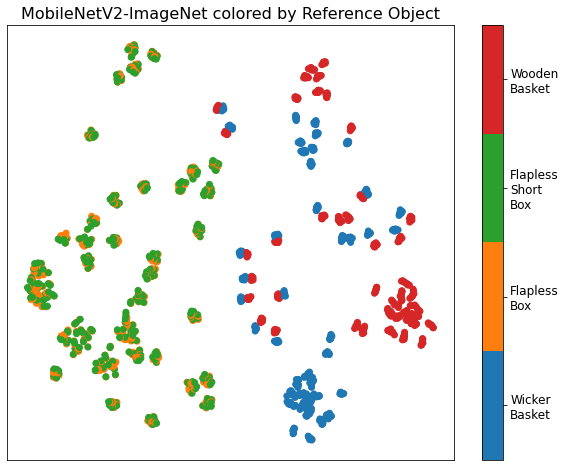

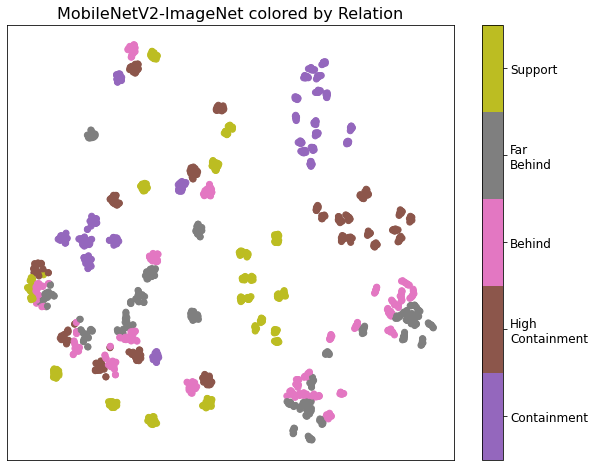

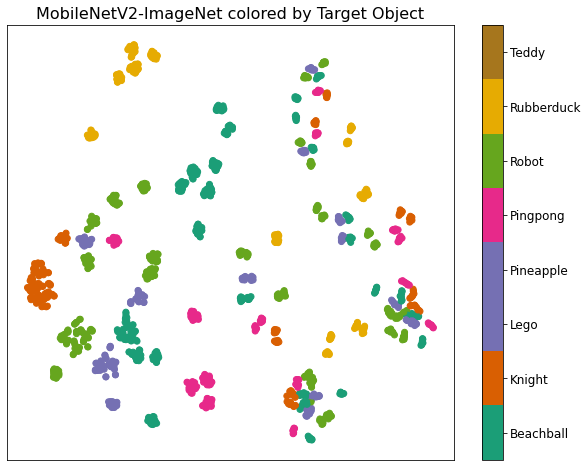

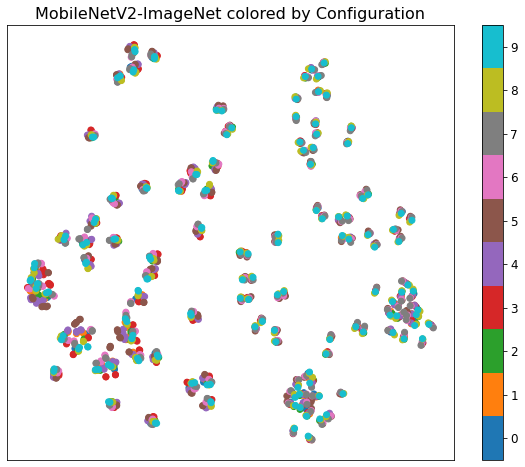

# mobilenet-random

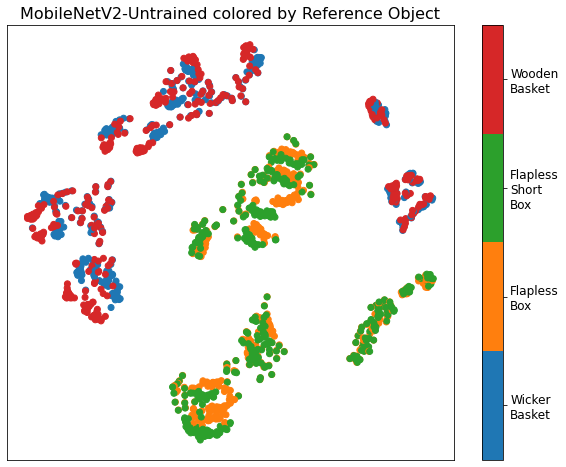

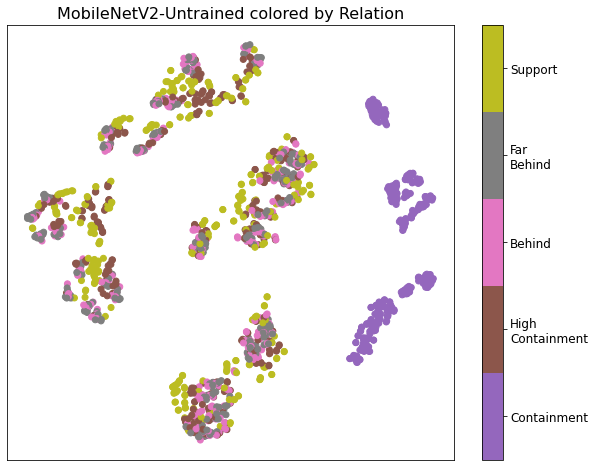

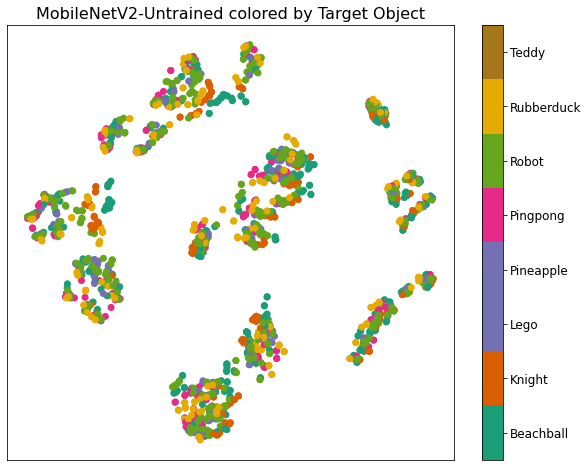

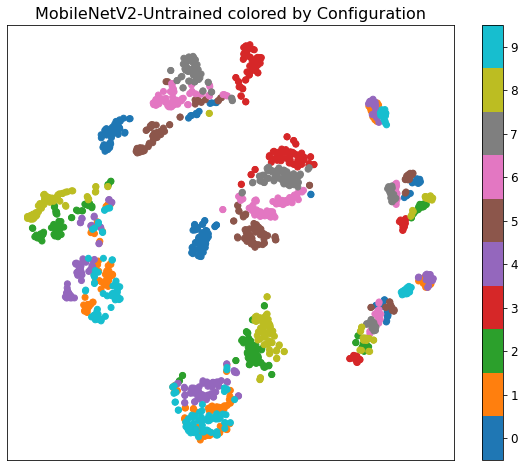

# resnext-saycam(S)

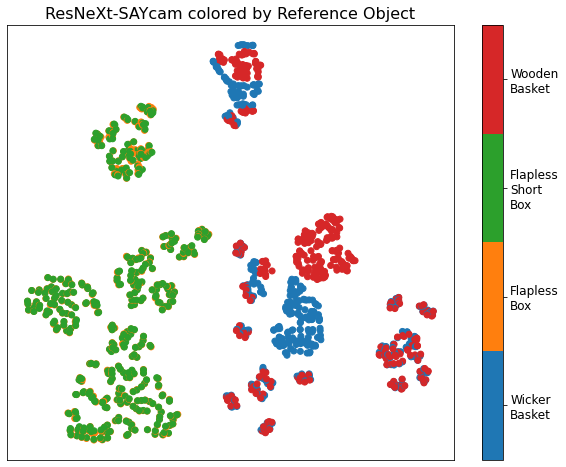

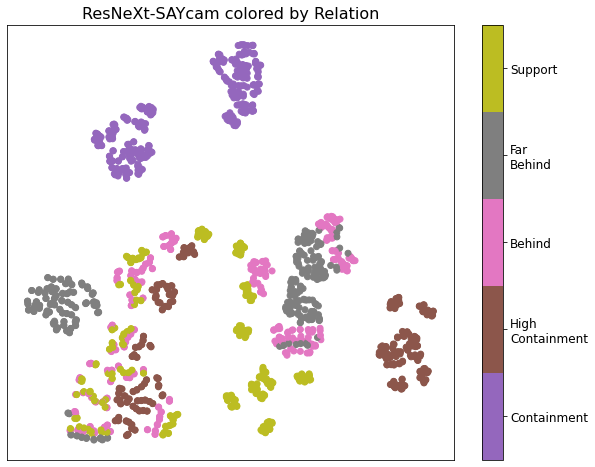

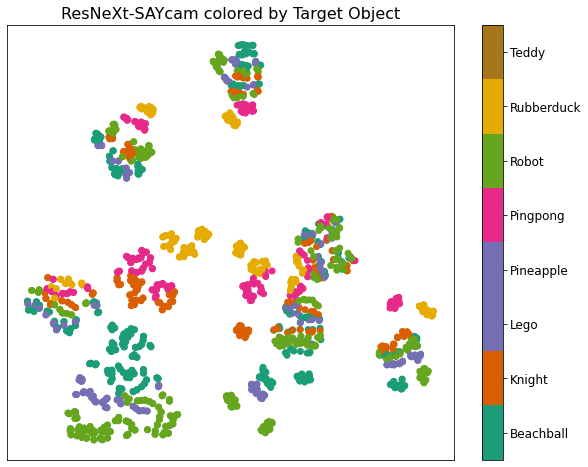

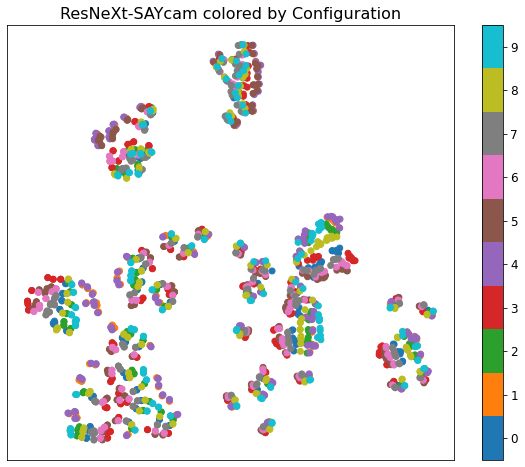

# resnext-imagenet

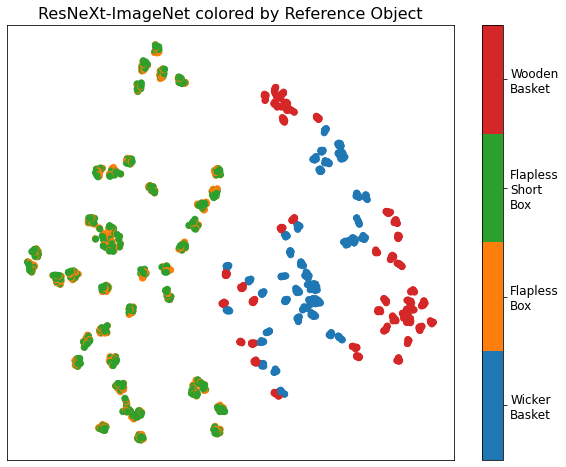

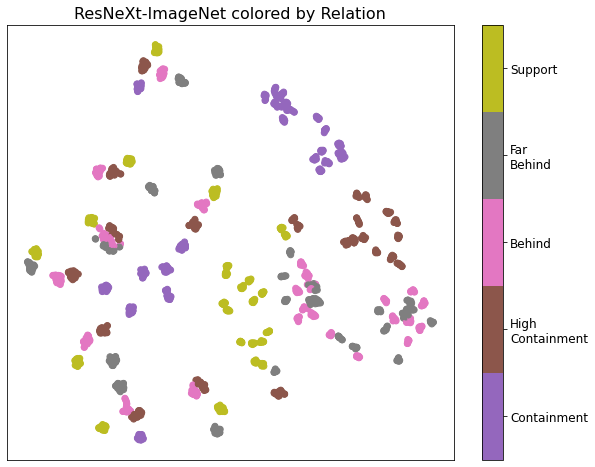

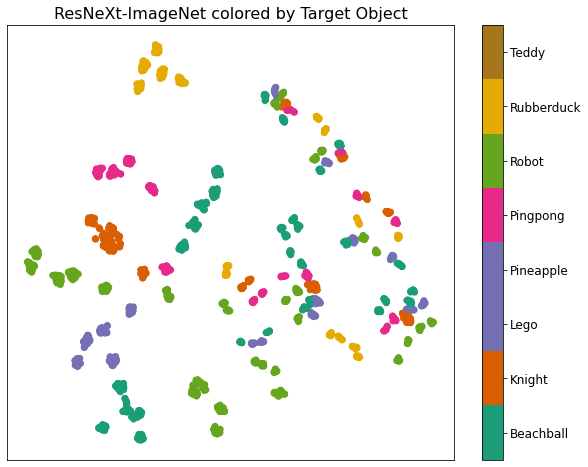

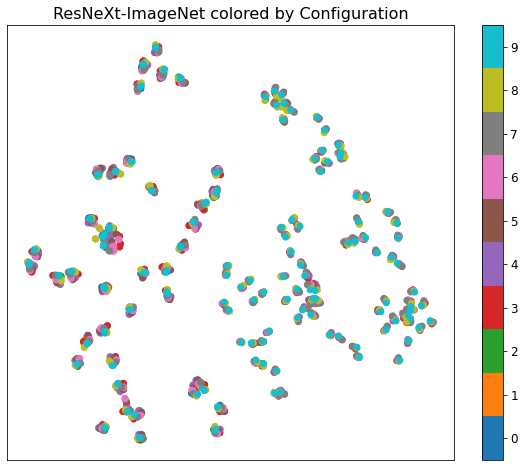

# resnext-random

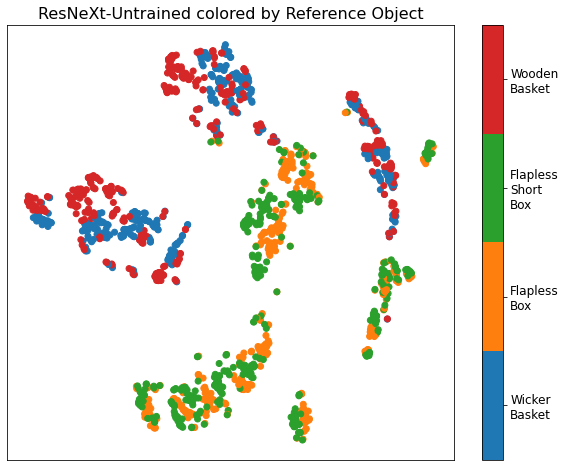

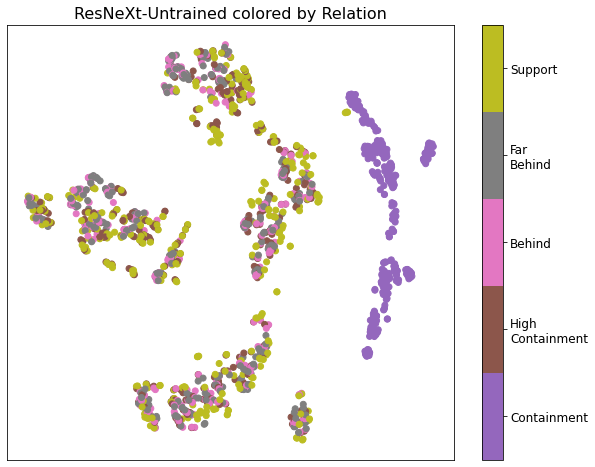

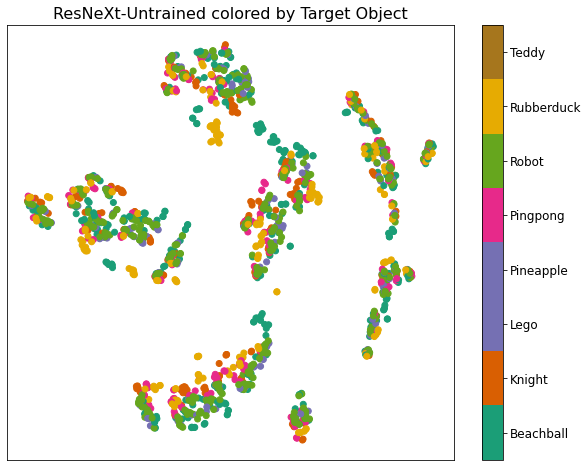

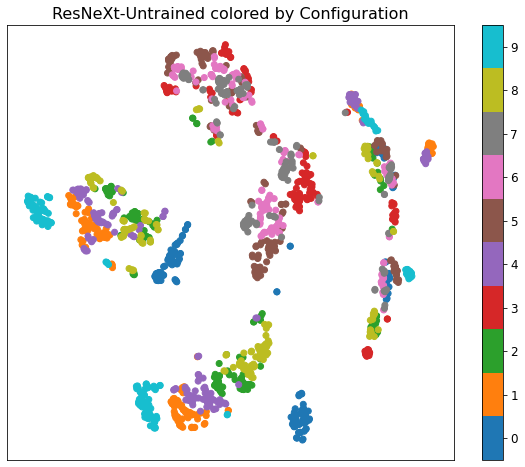

# resnext-saycam(S)-s

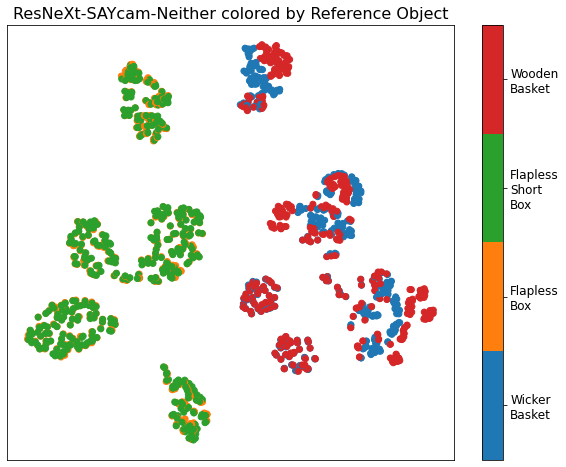

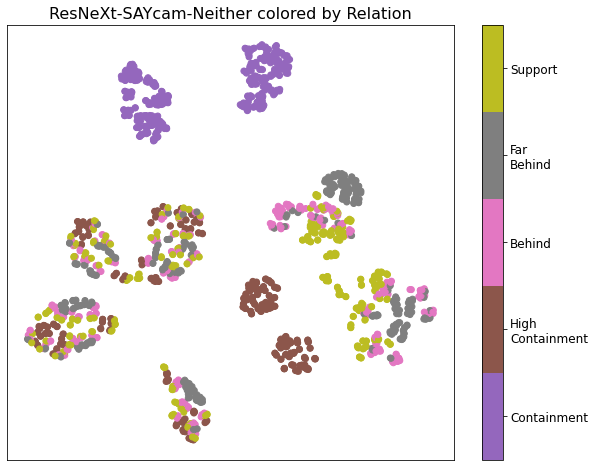

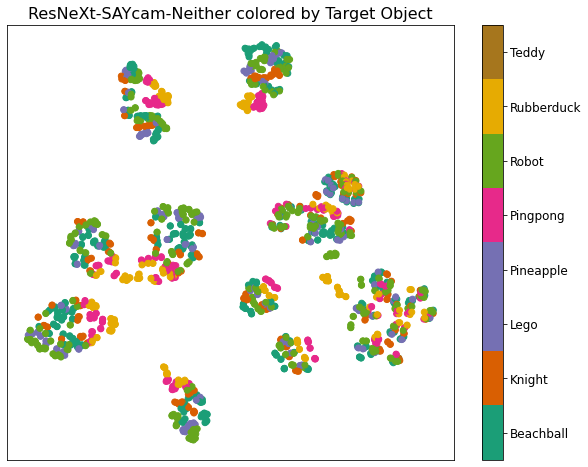

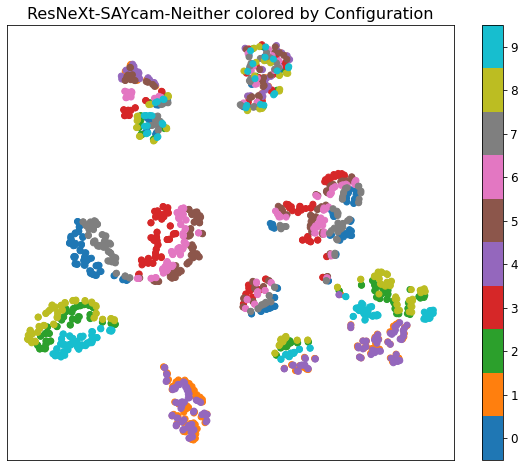

# resnext-saycam(S)-h

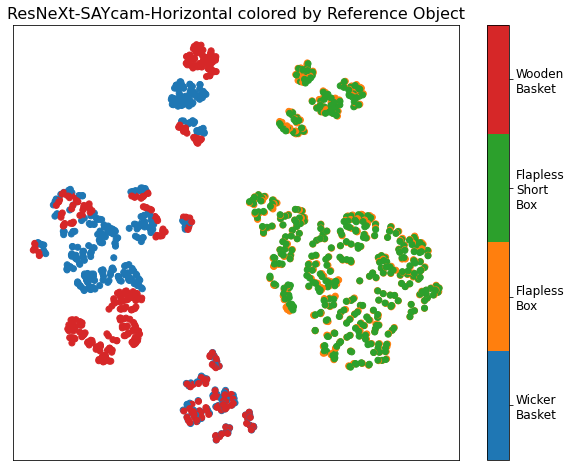

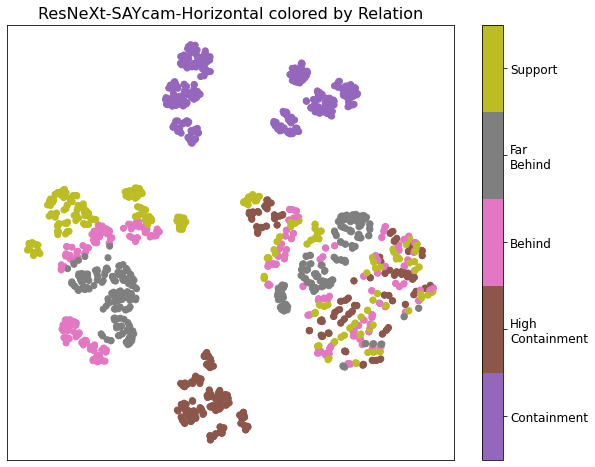

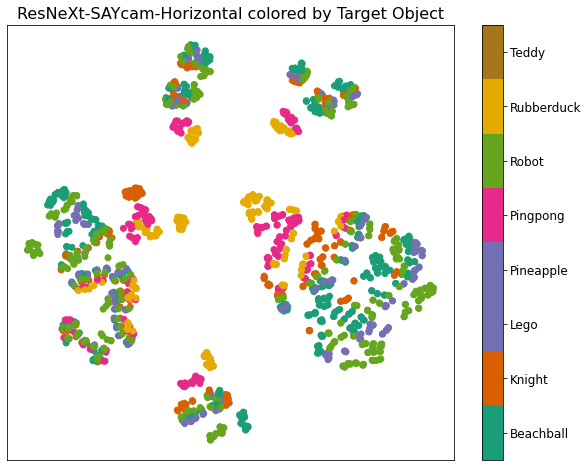

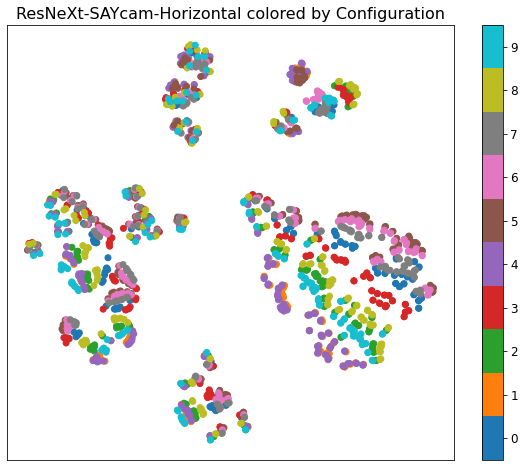

# resnext-saycam(S)-v

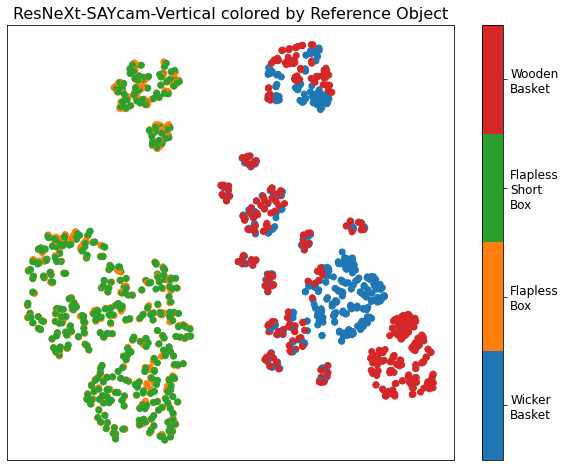

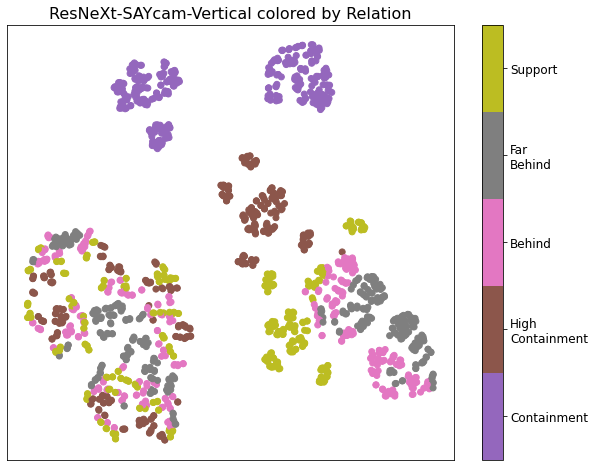

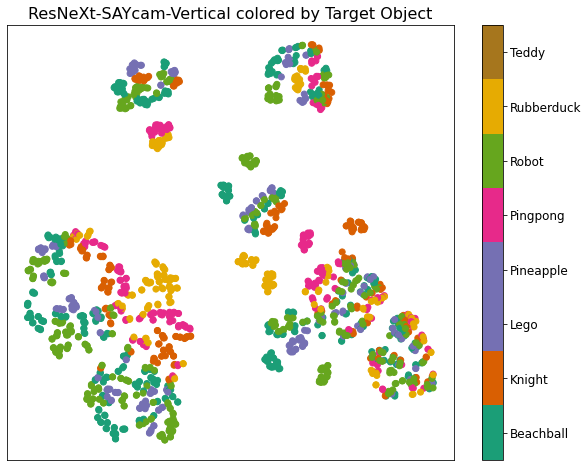

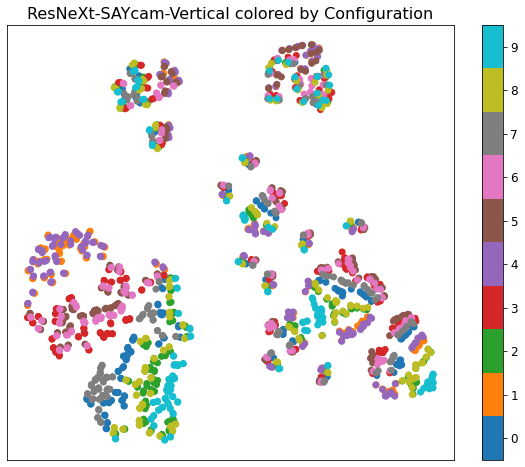

# resnext-saycam(S)-hv

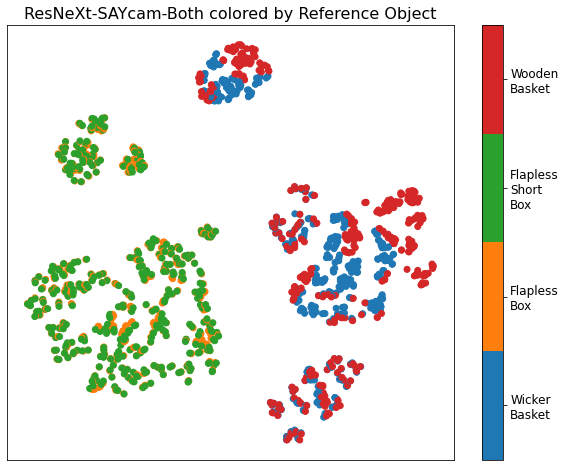

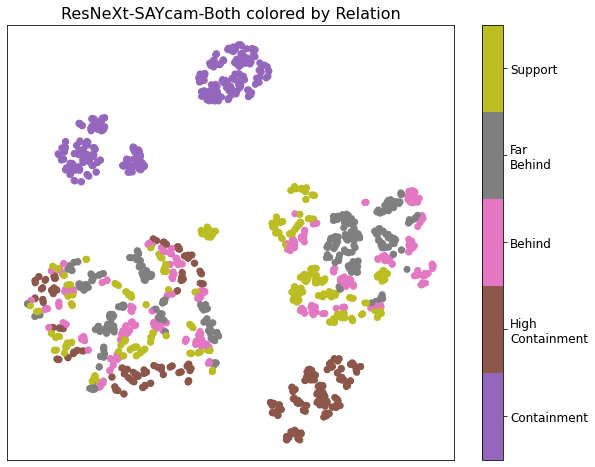

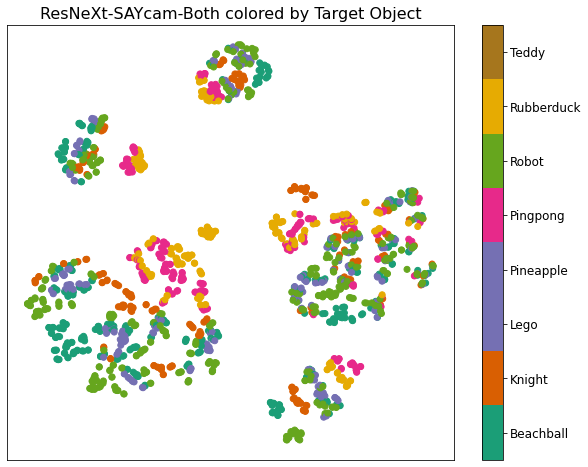

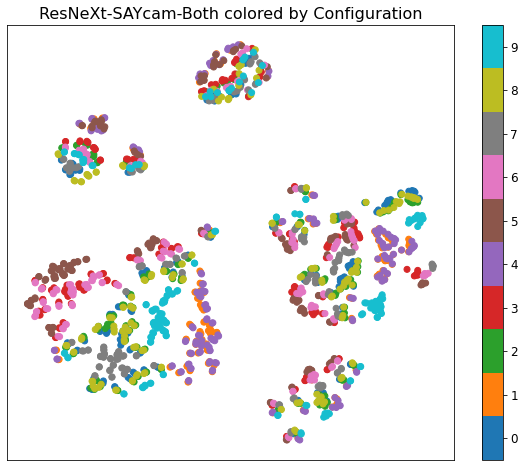

# resnext-DINO-S

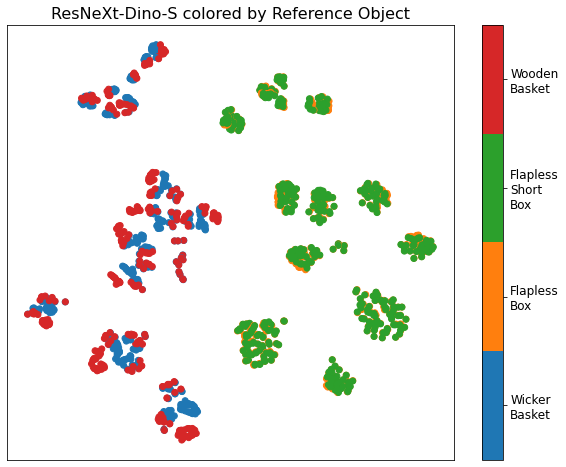

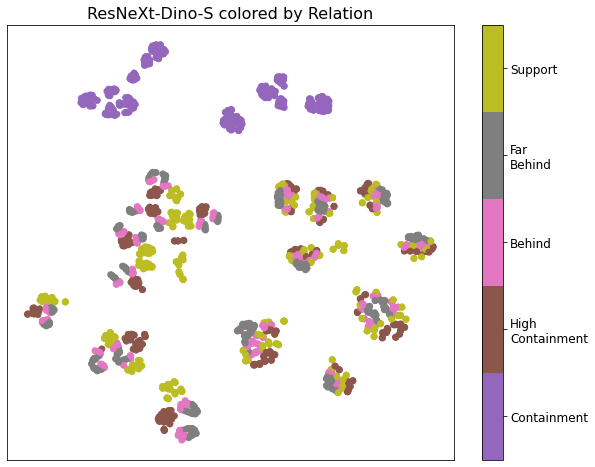

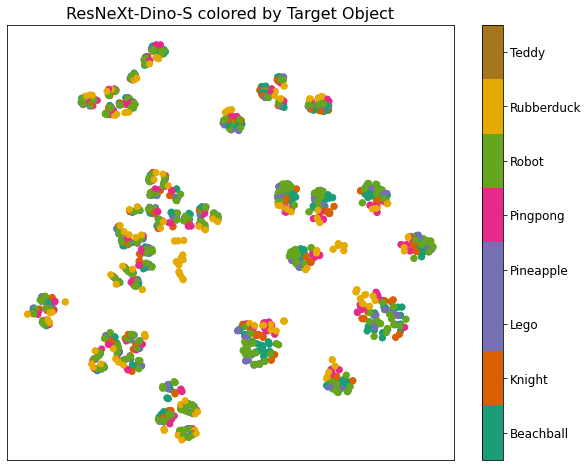

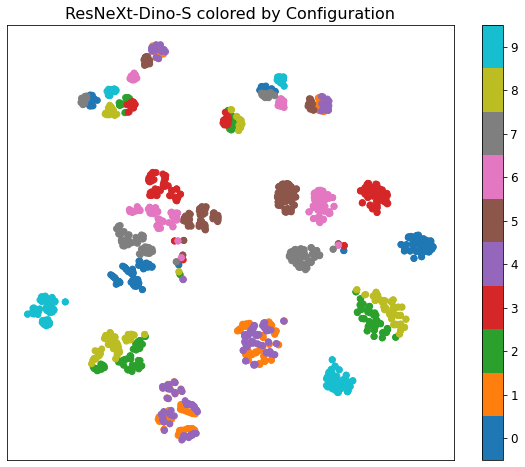

# resnext-DINO-ImageNet

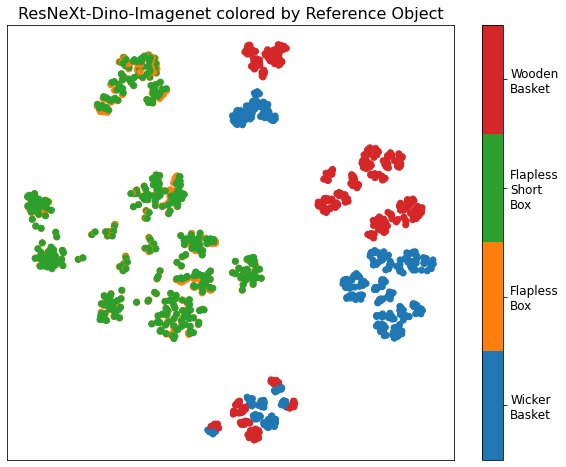

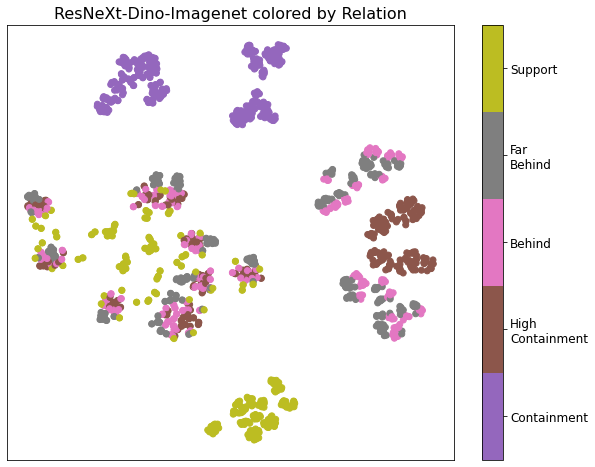

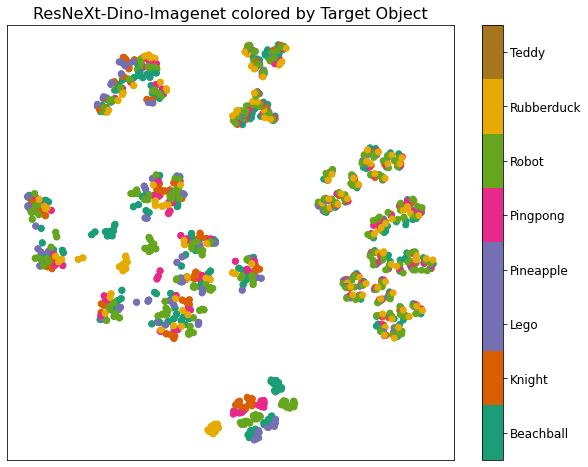

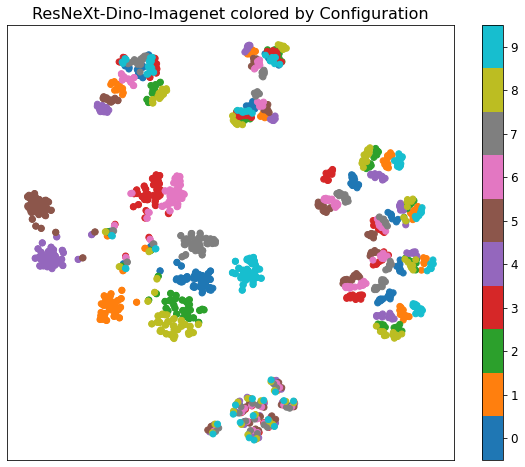

In [106]:
for model_key in tsne_results:
    display(Markdown(f'# {model_key}'))
    plot_tsne_results(tsne_results, model_key, REFERENCE_OBJECT, dataset)
    plot_tsne_results(tsne_results, model_key, RELATION, dataset, index_shift=4)
    plot_tsne_results(tsne_results, model_key, TARGET_OBJECT, dataset, cmap='Dark2')
    plot_tsne_results(tsne_results, model_key, CONFIGURATION, dataset)

# Quinn stuff

In [20]:
quinn_above_below_tsne_outputs = load_tsne_outputs('quinn_above_below_tsne.pkl.gz', '../containment_support_outputs/')
print(quinn_above_below_tsne_outputs.keys())
print(quinn_above_below_tsne_outputs['mobilenet-random'].shape, type(quinn_above_below_tsne_outputs['mobilenet-random']))

quinn_above_below_dataset = ContainmentSupportDataset('/Users/guydavidson/projects/BlockWorld/outputs/quinn_above_below_tsne', scene_types=QUINN_SCENE_TYPES)
quinn_above_below_dataset.dataset.shape

quinn_above_below_tsne_results = {}
for key, outputs in quinn_above_below_tsne_outputs.items():
    print(f'Starting t-SNE for {key}')
    quinn_above_below_tsne_results[key] = pca_and_tsne(outputs)

dict_keys(['mobilenet-saycam(S)', 'mobilenet-imagenet', 'mobilenet-random', 'resnext-saycam(S)', 'resnext-imagenet', 'resnext-random', 'resnext-saycam(S)-s', 'resnext-saycam(S)-h', 'resnext-saycam(S)-v', 'resnext-saycam(S)-hv', 'resnext-DINO-S', 'resnext-DINO-ImageNet'])
(320, 3, 1280) <class 'numpy.ndarray'>


100%|██████████| 320/320 [00:09<00:00, 32.91it/s]


Starting t-SNE for mobilenet-saycam(S)
Starting t-SNE for mobilenet-imagenet
Starting t-SNE for mobilenet-random
Starting t-SNE for resnext-saycam(S)
Starting t-SNE for resnext-imagenet
Starting t-SNE for resnext-random
Starting t-SNE for resnext-saycam(S)-s
Starting t-SNE for resnext-saycam(S)-h
Starting t-SNE for resnext-saycam(S)-v
Starting t-SNE for resnext-saycam(S)-hv
Starting t-SNE for resnext-DINO-S
Starting t-SNE for resnext-DINO-ImageNet


In [21]:
quinn_between_tsne_outputs = load_tsne_outputs('quinn_between_tsne.pkl.gz', '../containment_support_outputs/')
print(quinn_between_tsne_outputs.keys())
print(quinn_between_tsne_outputs['mobilenet-random'].shape, type(quinn_between_tsne_outputs['mobilenet-random']))

quinn_between_dataset = ContainmentSupportDataset('/Users/guydavidson/projects/BlockWorld/outputs/quinn_between_tsne', scene_types=QUINN_SCENE_TYPES)
quinn_between_dataset.dataset.shape


quinn_between_tsne_results = {}
for key, outputs in quinn_between_tsne_outputs.items():
    print(f'Starting t-SNE for {key}')
    quinn_between_tsne_results[key] = pca_and_tsne(outputs)

dict_keys(['mobilenet-saycam(S)', 'mobilenet-imagenet', 'mobilenet-random', 'resnext-saycam(S)', 'resnext-imagenet', 'resnext-random', 'resnext-saycam(S)-s', 'resnext-saycam(S)-h', 'resnext-saycam(S)-v', 'resnext-saycam(S)-hv', 'resnext-DINO-S', 'resnext-DINO-ImageNet'])
(320, 3, 1280) <class 'numpy.ndarray'>


100%|██████████| 320/320 [00:09<00:00, 32.01it/s]


Starting t-SNE for mobilenet-saycam(S)
Starting t-SNE for mobilenet-imagenet
Starting t-SNE for mobilenet-random
Starting t-SNE for resnext-saycam(S)
Starting t-SNE for resnext-imagenet
Starting t-SNE for resnext-random
Starting t-SNE for resnext-saycam(S)-s
Starting t-SNE for resnext-saycam(S)-h
Starting t-SNE for resnext-saycam(S)-v
Starting t-SNE for resnext-saycam(S)-hv
Starting t-SNE for resnext-DINO-S
Starting t-SNE for resnext-DINO-ImageNet


# mobilenet-saycam(S)

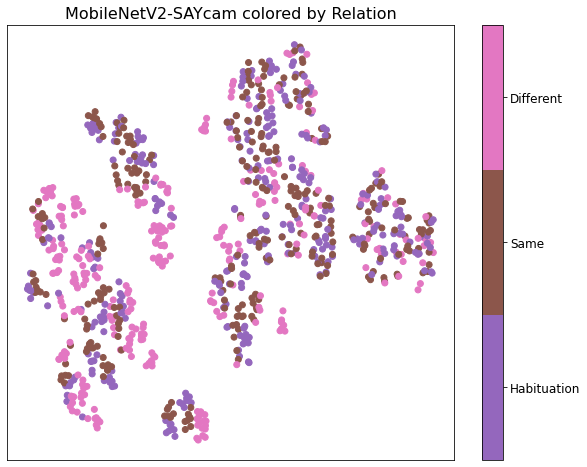

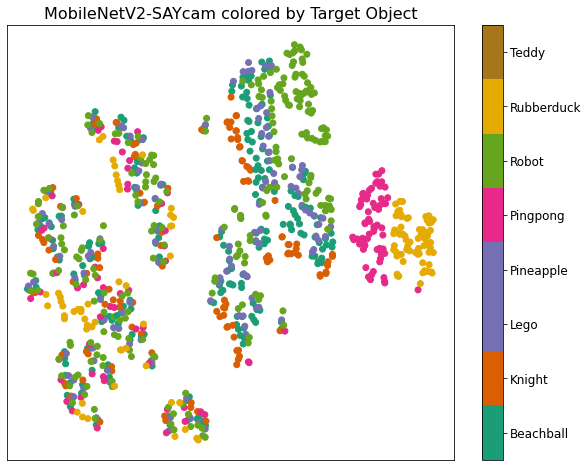

# mobilenet-imagenet

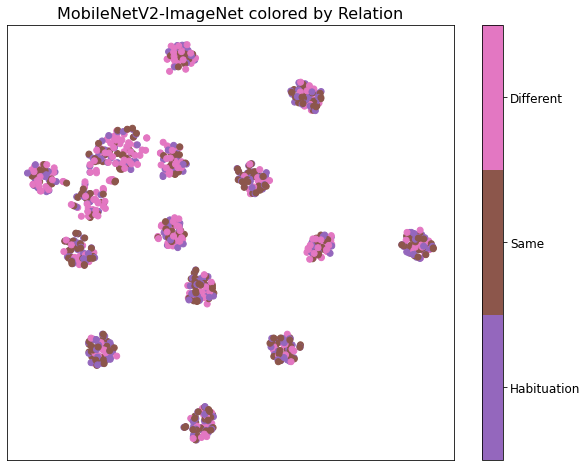

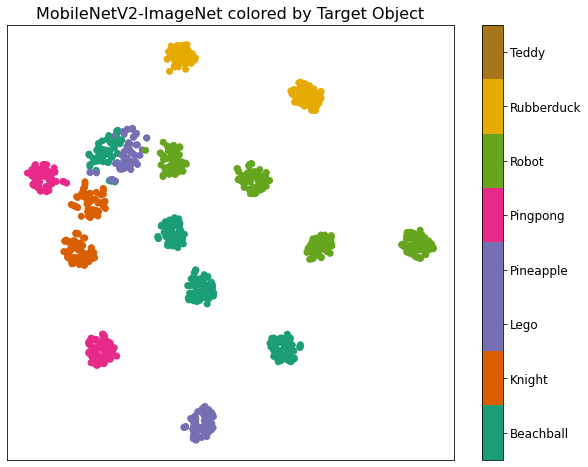

# mobilenet-random

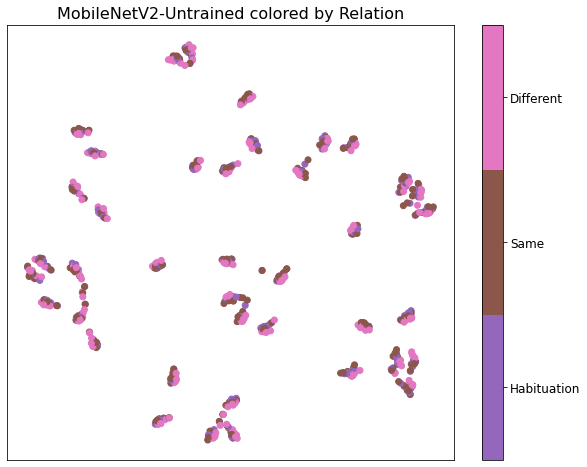

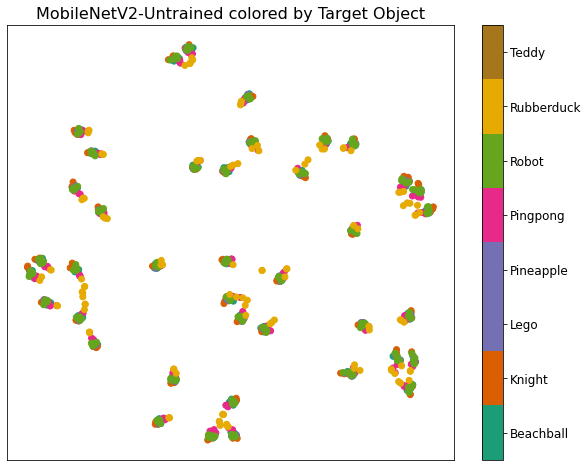

# resnext-saycam(S)

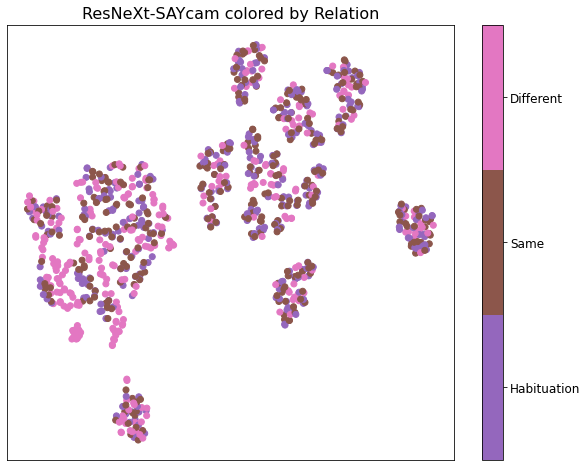

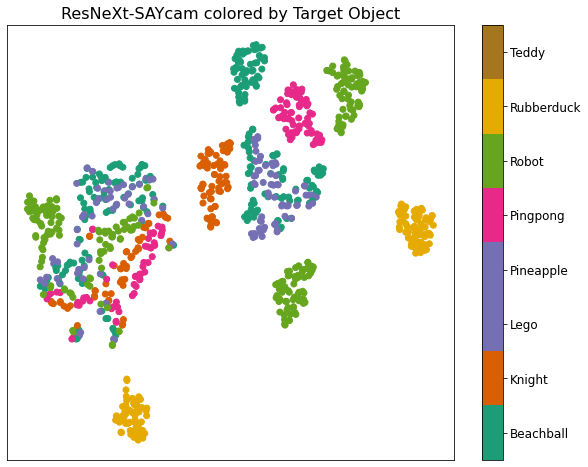

# resnext-imagenet

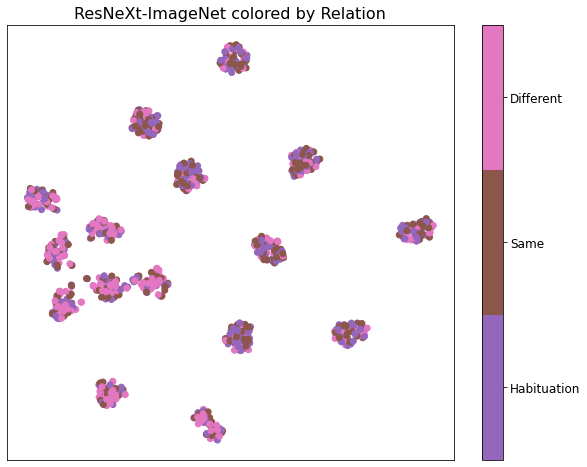

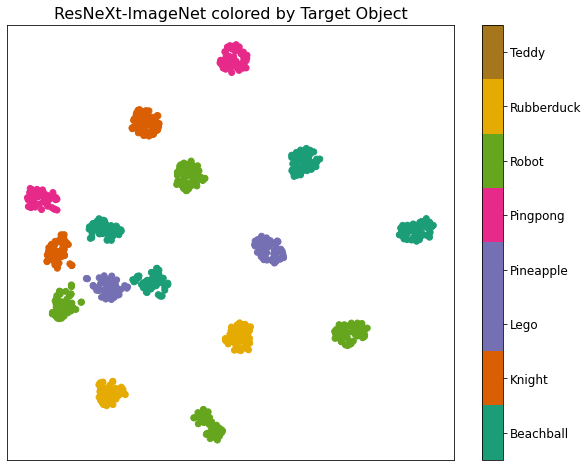

# resnext-random

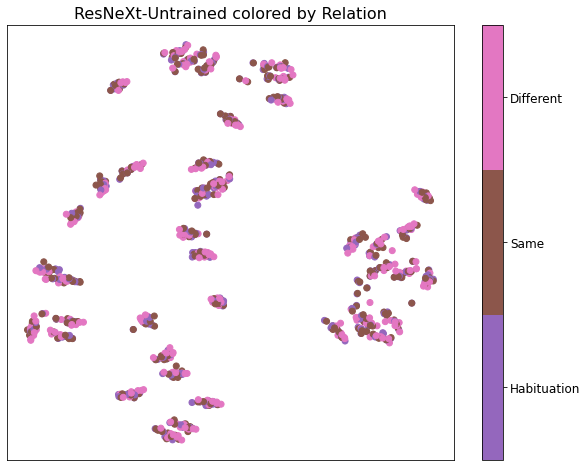

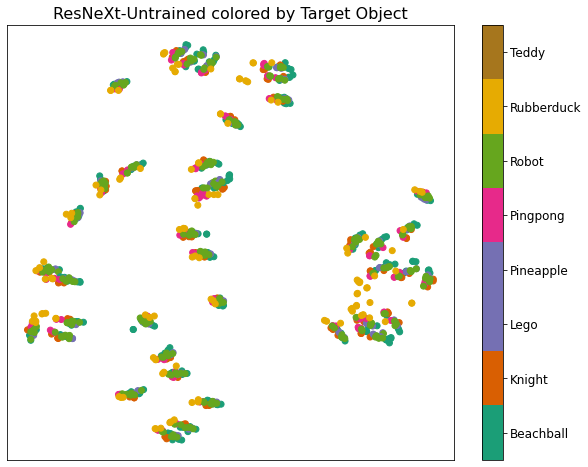

# resnext-saycam(S)-s

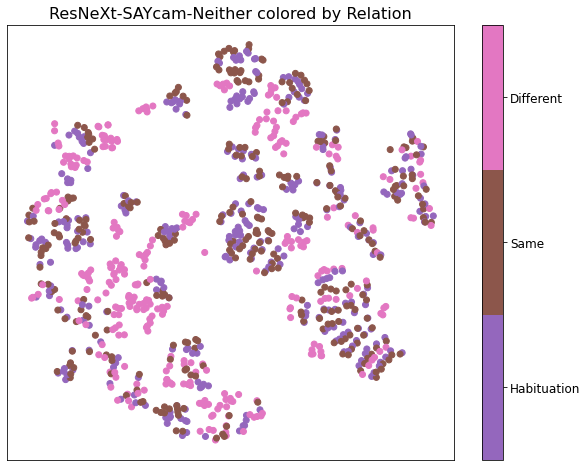

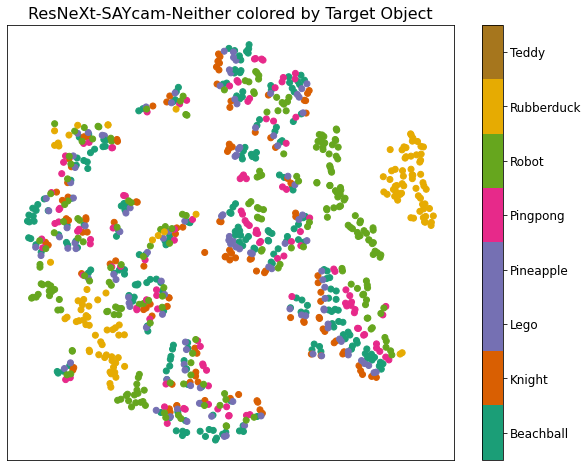

# resnext-saycam(S)-h

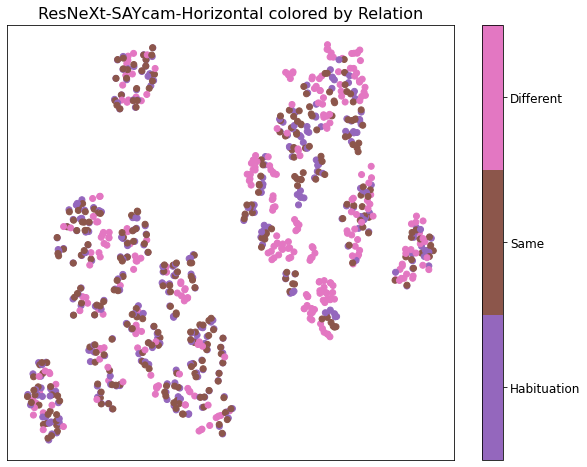

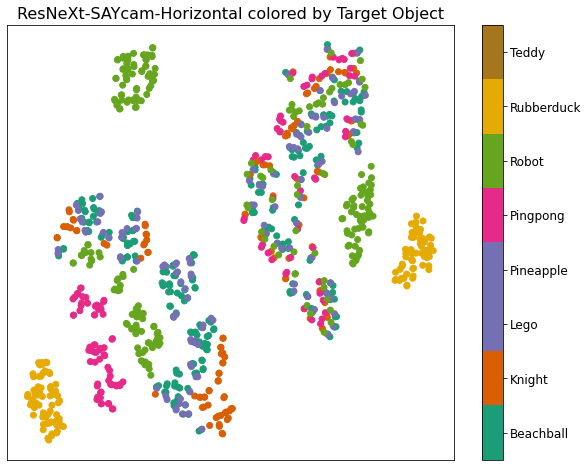

# resnext-saycam(S)-v

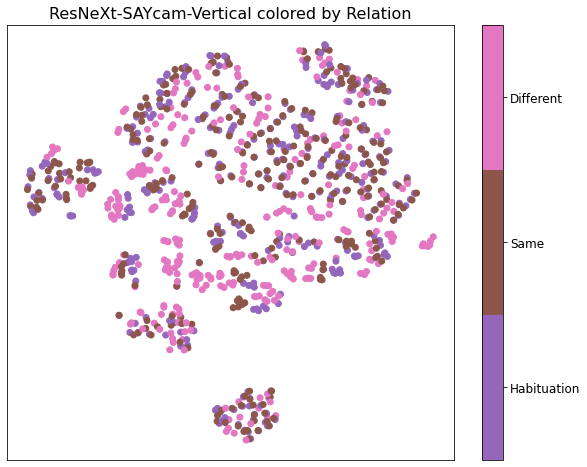

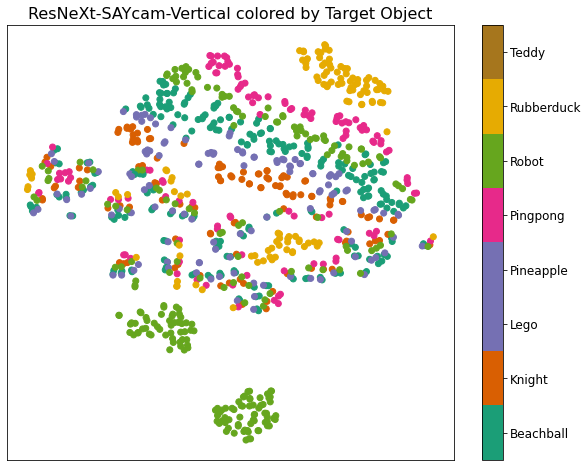

# resnext-saycam(S)-hv

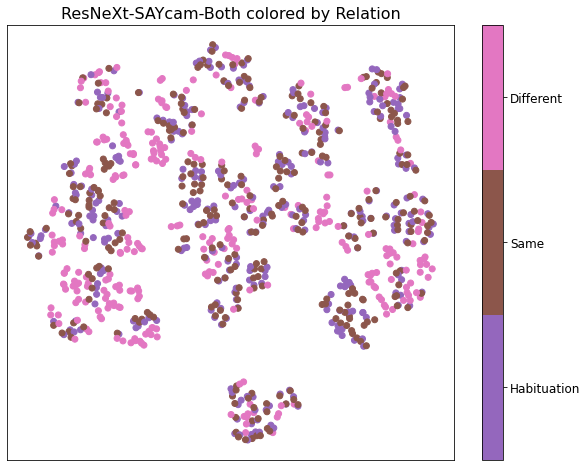

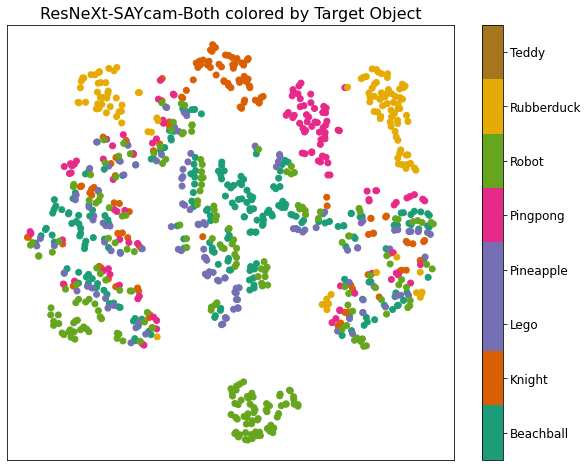

# resnext-DINO-S

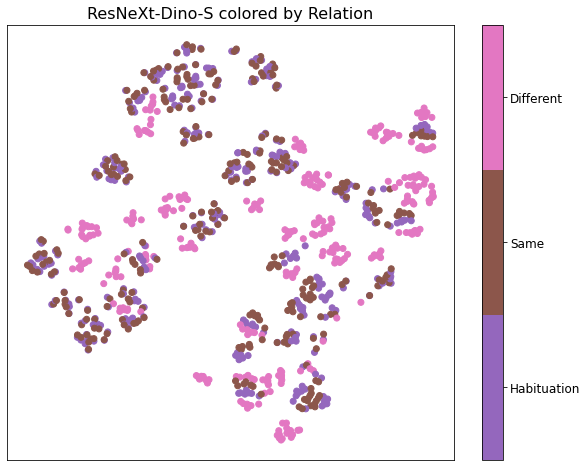

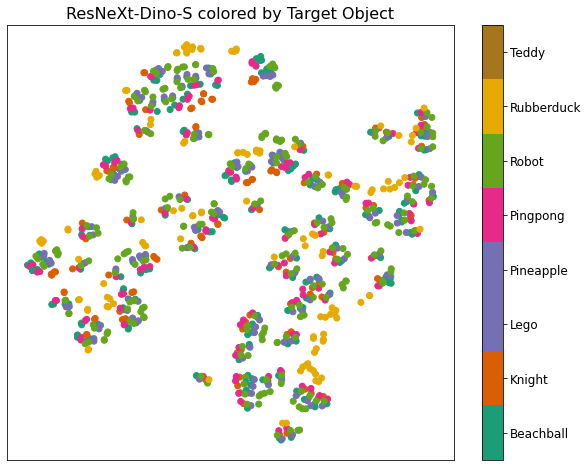

# resnext-DINO-ImageNet

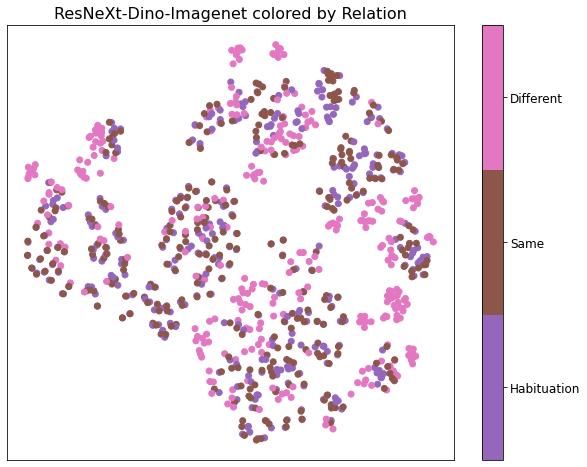

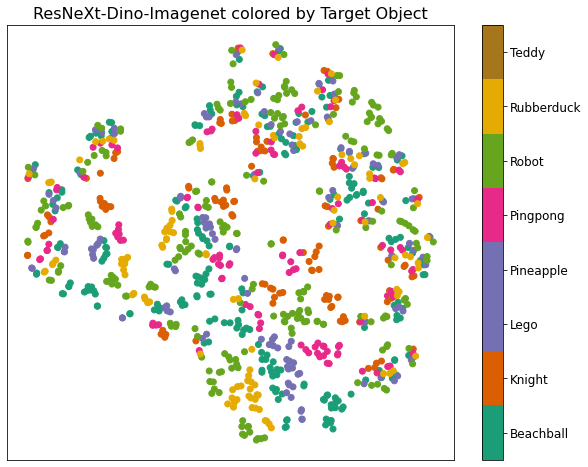

In [24]:
for model_key in quinn_above_below_tsne_outputs:
    display(Markdown(f'# {model_key}'))
    # plot_tsne_results(tsne_results, model_key, REFERENCE_OBJECT, dataset)
    plot_tsne_results(quinn_above_below_tsne_results, model_key, RELATION, quinn_above_below_dataset, index_shift=4)
    plot_tsne_results(quinn_above_below_tsne_results, model_key, TARGET_OBJECT, quinn_above_below_dataset, cmap='Dark2')
    # plot_tsne_results(tsne_results, model_key, CONFIGURATION, dataset)